In [ ]:
import tensorflow as tf

#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

import pickle

from keras.utils.vis_utils import plot_model

### GENERATE DATA

In [ ]:
# CASE 1 - variable mu_1, mu_2, constant sigma_1, sigma_2, rho

def create_sine_data_1(n = 3000):

    np.random.seed(32)
    t = np.linspace(0,2*np.pi,n)

    x1 = 0.5+np.sin(t)
    x2 = np.cos(t)

    mean_list = list(zip(x1,x2))

    sigma_1 = .1
    sigma_2 = .15
    rho = 0.5

    new_x1 = []
    new_x2 = []

    for zz1, zz2 in zip(x1, x2):

        cov = [[np.square(sigma_1), rho*sigma_1*sigma_2], [rho*sigma_1*sigma_2, np.square(sigma_2)]]

        rand_multi = np.random.multivariate_normal((0,0), cov, 1)

        new_x1.append(zz1 + rand_multi[0][0])
        new_x2.append(zz2 + rand_multi[0][1])

    x1 = np.concatenate((np.ones(int(n/10))*0.5, new_x1, np.ones(int(n/10))*0.5))
    x2 = np.concatenate((np.ones(int(n/10)), new_x2, np.ones(int(n/10))))

    t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))

    return t_, x1, x2

In [ ]:
# CASE 2 - variable mu_1, mu_2, sigma_1, sigma_2, constant rho

def create_sine_data_2(n = 3000):

    np.random.seed(32)
    t = np.linspace(0,2*np.pi,n)

    x1 = 0.5+np.sin(t)
    x2 = np.cos(t)

    sigma_1 = .1
    sigma_2 = .15
    rho = 0.5

    new_x1 = []
    new_x2 = []

    for zz1, zz2 in zip(x1, x2):

        cov = [[np.square(sigma_1*np.abs(zz1)), rho*sigma_1*sigma_2*np.abs(zz1)*np.abs(zz2)], [rho*sigma_1*sigma_2*np.abs(zz1)*np.abs(zz2), np.square(sigma_2*np.abs(zz2))]]

        rand_multi = np.random.multivariate_normal((0, 0), cov, 1)

        new_x1.append(zz1 + rand_multi[0][0])
        new_x2.append(zz2 + rand_multi[0][1])

    x1 = np.concatenate((np.ones(int(n/10))*0.5, new_x1, np.ones(int(n/10))*0.5))
    x2 = np.concatenate((np.ones(int(n/10)), new_x2, np.ones(int(n/10))))

    t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))

    return t_, x1, x2

In [ ]:
# CASE 3 - variable mu_1, mu_2, sigma_1, sigma_2, rho

def create_sine_data_3(n = 3000):

    np.random.seed(32)
    t = np.linspace(0,2*np.pi,n)

    x1 = 0.5+np.sin(t)
    x2 = np.cos(t)

    sigma_1 = .1
    sigma_2 = .15
    rho = 0.5

    new_x1 = []
    new_x2 = []

    for zz1, zz2 in zip(x1, x2):

        cov = [[np.square(sigma_1)*np.abs(zz1), rho*sigma_1*sigma_2*np.abs(zz1)*np.abs(zz2)], [rho*sigma_1*sigma_2*np.abs(zz1)*np.abs(zz2), np.square(sigma_2)*np.abs(zz2)]]

        rand_multi = np.random.multivariate_normal((0, 0), cov, 1)

        new_x1.append(zz1 + rand_multi[0][0])
        new_x2.append(zz2 + rand_multi[0][1])

    x1 = np.concatenate((np.ones(int(n/10))*0.5, new_x1, np.ones(int(n/10))*0.5))
    x2 = np.concatenate((np.ones(int(n/10)), new_x2, np.ones(int(n/10))))

    t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))

    return t_, x1, x2

## LOSS FUNCTION

In [ ]:
def my_NLL_loss(y_true,y_pred):

  y_true_1=tf.slice(y_true,[0,0],[-1,1])
  y_true_2=tf.slice(y_true,[0,1],[-1,1])

  mu_1  = tf.slice(y_pred,[0,0],[-1,1])
  mu_2 = tf.slice(y_pred,[0,1],[-1,1])
  sigma_1 = tf.math.exp(tf.slice(y_pred,[0,2],[-1,1]))
  sigma_2 = tf.math.exp(tf.slice(y_pred,[0,3],[-1,1]))

  rho = 2*tf.math.sigmoid(tf.slice(y_pred,[0,4],[-1,1])) - 1  # Chcę aby było w zakresie [-1, 1]

  a=sigma_1*sigma_2*tf.sqrt(1-tf.square(rho))
  # a=tf.math.divide(1, sigma_1*sigma_2)

  b1=tf.square((mu_1-y_true_1)/sigma_1) + tf.square((mu_2-y_true_2)/sigma_2) - 2.*rho*((mu_1-y_true_1)*(mu_2-y_true_2)/(sigma_1*sigma_2))
  b2=2*(1-tf.square(rho))
  b=b1/b2

  #a = 1/(tf.sqrt(2.*math.pi)*sigma_1*sigma_2)

  loss = tf.reduce_sum(tf.math.log(a)+ b,axis=0)

  return loss

## CASE 1 - variable mu_1, mu_2 and constant sigma_1, sigma_2, rho

In [ ]:
t_, x1, x2 = create_sine_data_1(n = 3000)

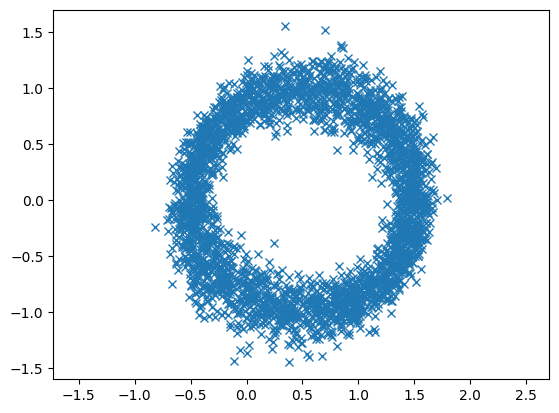

In [ ]:
plt.plot(x1, x2, 'x')
plt.axis('equal')

plt.savefig("case1_x1x2.png")
plt.show()

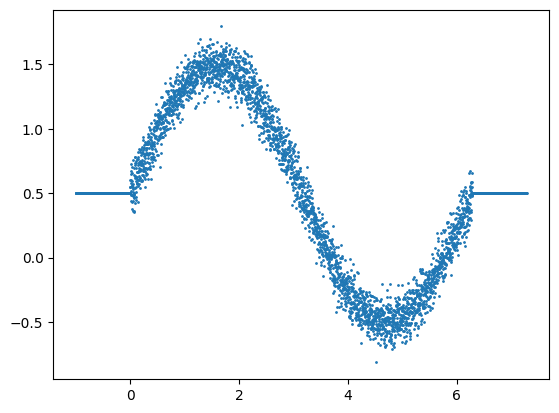

In [ ]:
plt.scatter(t_, x1,marker='o', s=1)

plt.savefig("case1_x1.png")
plt.show()


plt.show()

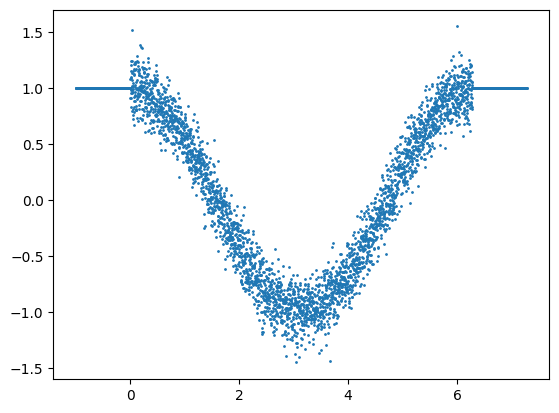

In [ ]:
plt.scatter(t_, x2,marker='o', s=1)

plt.savefig("case1_x2.png")
plt.show()

plt.show()

In [ ]:
model =  Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])
# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 5)                 105       
                                                                 
Total params: 2,215
Trainable params: 2,215
Non-trainable params: 0
_________________________________________________________________


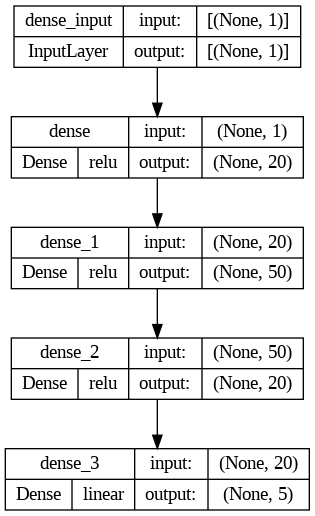

In [ ]:
plot_model(model, to_file='model_case_01_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
x = np.array([x1,x2]).T
x = x.astype("float32")

T  = (t_ - t_.min(axis=0)) / (t_.max(axis=0) - t_.min(axis=0))
T = T.astype("float32")

In [ ]:
history=model.fit(T, x,
                  batch_size=16,
                  epochs=1000,
                  verbose=1
                 )

Epoch 1/1000
225/225 [==============================] - 11s 6ms/step - loss: 2.0197 - my_NLL_loss: 2.0197
Epoch 2/1000
225/225 [==============================] - 2s 6ms/step - loss: -20.2802 - my_NLL_loss: -20.2802
Epoch 3/1000
225/225 [==============================] - 1s 6ms/step - loss: -37.6638 - my_NLL_loss: -37.6638
Epoch 4/1000
225/225 [==============================] - 1s 7ms/step - loss: -40.3700 - my_NLL_loss: -40.3700
Epoch 5/1000
225/225 [==============================] - 1s 7ms/step - loss: -42.0070 - my_NLL_loss: -42.0070
Epoch 6/1000
225/225 [==============================] - 2s 7ms/step - loss: -43.8971 - my_NLL_loss: -43.8971
Epoch 7/1000
225/225 [==============================] - 2s 9ms/step - loss: -45.8824 - my_NLL_loss: -45.8824
Epoch 8/1000
225/225 [==============================] - 2s 8ms/step - loss: -48.2371 - my_NLL_loss: -48.2371
Epoch 9/1000
225/225 [==============================] - 2s 7ms/step - loss: -50.7502 - my_NLL_loss: -50.7502
Epoch 10/1000
225/225 

In [ ]:
prediction = model.predict(T)

file = open('case1_result', 'wb')
pickle.dump(prediction, file)
file.close()

pred_mu_1=prediction[:,0]
pred_mu_2=prediction[:,1]
pred_log_sigma_1=prediction[:,2]
pred_log_sigma_2=prediction[:,3]
pred_rho=prediction[:,4]

pred_rho=2*tf.math.sigmoid(pred_rho) - 1

113/113 [==============================] - 0s 2ms/step


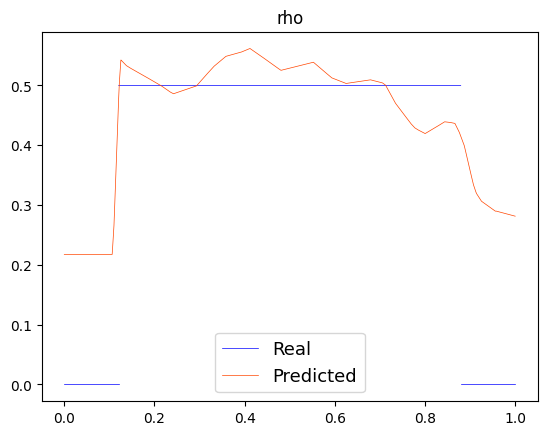

In [ ]:
n = 3000

t = np.linspace(0,2*np.pi,n)
rho_theoretical = [.5 for i in range(len(t))]

plt.plot(T[:int(n/10)], np.zeros(int(n/10)), 'blue', linewidth=0.5, label = 'Real')
plt.plot(T[int(n/10):-int(n/10)], rho_theoretical, 'blue', linewidth=0.5)
plt.plot(T[-int(n/10):], np.zeros(int(n/10)), 'blue', linewidth=0.5)

plt.plot(T, pred_rho, 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('rho')
plt.legend(loc ="lower center", fontsize="13")

plt.savefig("case1_rho.png")

plt.show()


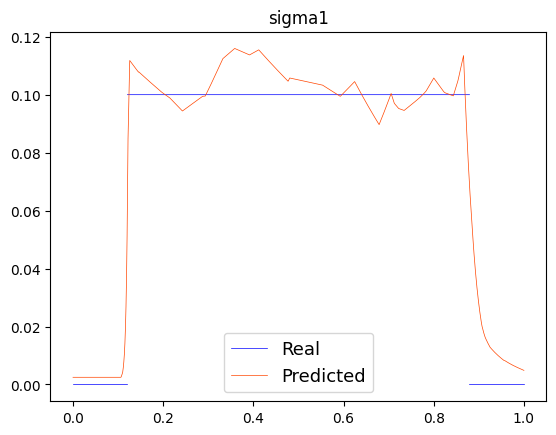

In [ ]:
n = 3000

t = np.linspace(0,2*np.pi,n)
sigma1_theoretical = [.1 for i in range(len(t))]

plt.plot(T[:int(n/10)], np.zeros(int(n/10)), 'blue', linewidth=0.5, label = 'Real')
plt.plot(T[int(n/10):-int(n/10)], sigma1_theoretical, 'blue', linewidth=0.5)
plt.plot(T[-int(n/10):], np.zeros(int(n/10)), 'blue', linewidth=0.5)
plt.plot(T,np.exp(pred_log_sigma_1), 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('sigma1')
plt.legend(loc ="lower center", fontsize="13")
plt.savefig("case1_sigma1.png")
plt.show()

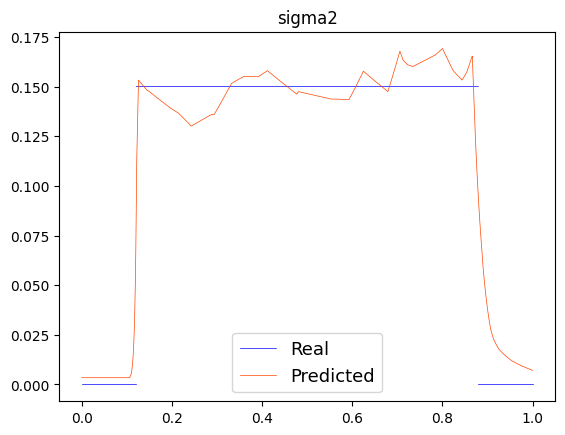

In [ ]:
t = np.linspace(0,2*np.pi,n)
sigma2_theoretical = [.15 for i in range(len(t))]

plt.plot(T[:int(n/10)], np.zeros(int(n/10)), 'blue', linewidth=0.5, label = 'Real')
plt.plot(T[int(n/10):-int(n/10)], sigma2_theoretical, 'blue', linewidth=0.5)
plt.plot(T[-int(n/10):], np.zeros(int(n/10)), 'blue', linewidth=0.5)
plt.plot(T,np.exp(pred_log_sigma_2), 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('sigma2')
plt.legend(loc ="lower center", fontsize="13")
plt.savefig("case1_sigma2.png")
plt.show()

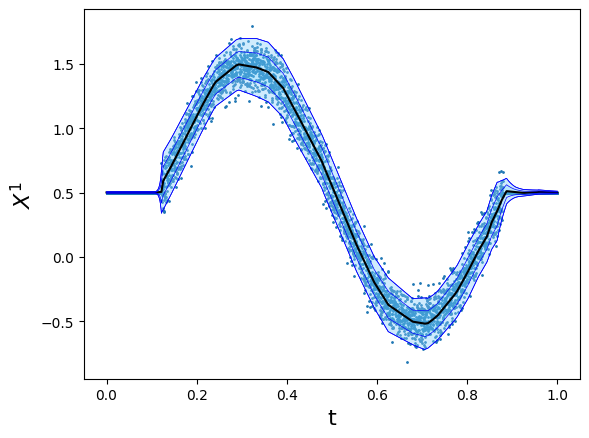

In [ ]:
# show the data along with the fit plus/minus 2-times the standard deviation
t_pred = T

plt.scatter(T,x1,marker='o', s=1)
plt.plot(t_pred,pred_mu_1,c="black",label='Fitted values')

pred_1_sd_p = pred_mu_1+(np.exp(pred_log_sigma_1))
pred_1_sd_m = pred_mu_1-(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_1+2*(np.exp(pred_log_sigma_1))
pred_2_sd_m = pred_mu_1-2*(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_1+2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_1-2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("Case 1 - simulated data $X^{1}(t)$", fontsize=16)
plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{1}$", fontsize=16)
plt.savefig("case1_x1_pred.png")
plt.show()

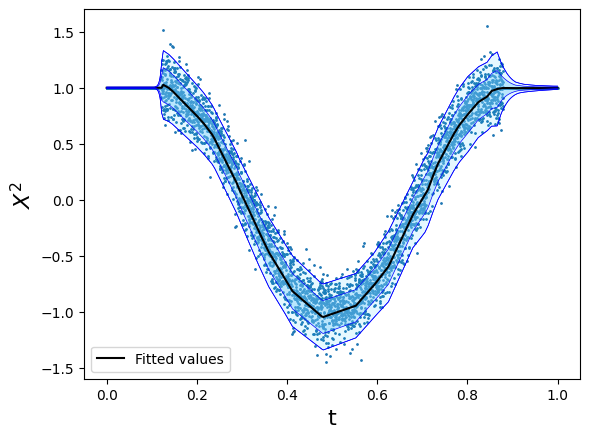

In [ ]:
plt.clf()

plt.scatter(T,x2,marker='o', s=1)
plt.plot(t_pred,pred_mu_2,c="black", label='Fitted values')

pred_1_sd_p = pred_mu_2+(np.exp(pred_log_sigma_2))
pred_1_sd_m = pred_mu_2-(np.exp(pred_log_sigma_2))

# plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
# plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_2+2*(np.exp(pred_log_sigma_2))
pred_2_sd_m = pred_mu_2-2*(np.exp(pred_log_sigma_2))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_2+2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_2-2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("Case 1 - simulated data $X^{2}(t)$", fontsize=16)
plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{2}$", fontsize=16)
plt.legend()
plt.savefig("case1_x2_pred.png")
plt.show()

## CASE 2 - zmienne mu_1, mu_2, sigma_1, sigma_2, i stałą korelację

In [ ]:
t_, x1, x2 = create_sine_data_2(n = 3000)

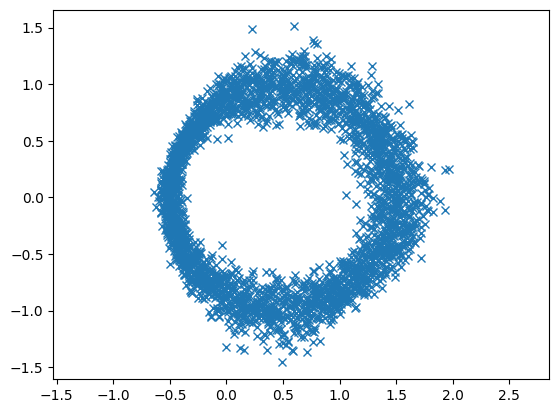

In [ ]:
plt.plot(x1, x2, 'x')
plt.axis('equal')
plt.savefig("case2_x1x2.png")
plt.show()

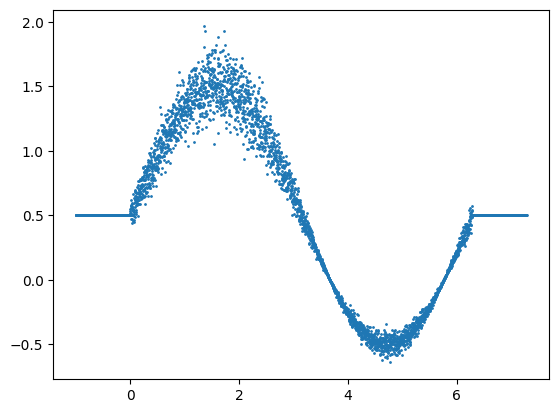

In [ ]:
plt.scatter(t_, x1,marker='o', s=1)
plt.savefig("case2_x1.png")
plt.show()

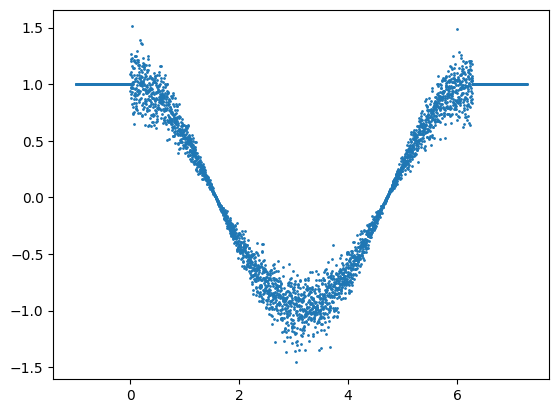

In [ ]:
plt.scatter(t_, x2,marker='o', s=1)
plt.savefig("case2_x2.png")
plt.show()

In [ ]:
model =  Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])
# summarize model along with number of model weights
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                40        
                                                                 
 dense_5 (Dense)             (None, 50)                1050      
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dense_7 (Dense)             (None, 5)                 105       
                                                                 
Total params: 2,215
Trainable params: 2,215
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x = np.array([x1,x2]).T
x = x.astype("float32")

T  = (t_ - t_.min(axis=0)) / (t_.max(axis=0) - t_.min(axis=0))
T = T.astype("float32")

In [ ]:
history=model.fit(T, x,
                  batch_size=16,
                  epochs=1000,
                  verbose=1
                 )

Epoch 1/1000
225/225 [==============================] - 3s 4ms/step - loss: 3.0710 - my_NLL_loss: 3.0710
Epoch 2/1000
225/225 [==============================] - 1s 4ms/step - loss: -16.5175 - my_NLL_loss: -16.5175
Epoch 3/1000
225/225 [==============================] - 1s 4ms/step - loss: -31.1348 - my_NLL_loss: -31.1348
Epoch 4/1000
225/225 [==============================] - 1s 4ms/step - loss: -41.5917 - my_NLL_loss: -41.5917
Epoch 5/1000
225/225 [==============================] - 1s 4ms/step - loss: -50.6097 - my_NLL_loss: -50.6097
Epoch 6/1000
225/225 [==============================] - 1s 4ms/step - loss: -54.2498 - my_NLL_loss: -54.2498
Epoch 7/1000
225/225 [==============================] - 1s 4ms/step - loss: -55.9596 - my_NLL_loss: -55.9596
Epoch 8/1000
225/225 [==============================] - 1s 5ms/step - loss: -57.5356 - my_NLL_loss: -57.5356
Epoch 9/1000
225/225 [==============================] - 1s 5ms/step - loss: -58.5645 - my_NLL_loss: -58.5645
Epoch 10/1000
225/225 [

In [ ]:
prediction = model.predict(T)

file = open('case2_result', 'wb')
pickle.dump(prediction, file)
file.close()

pred_mu_1=prediction[:,0]
pred_mu_2=prediction[:,1]
pred_log_sigma_1=prediction[:,2]
pred_log_sigma_2=prediction[:,3]
pred_rho=prediction[:,4]

pred_rho=2*tf.math.sigmoid(pred_rho) - 1

113/113 [==============================] - 0s 2ms/step


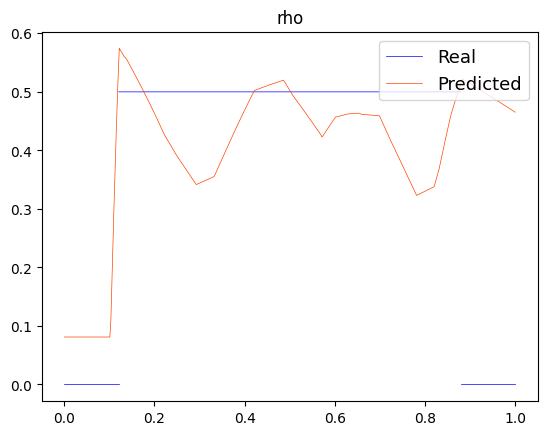

In [ ]:
# plt.plot(X, pred_rho, 'b', linewidth=0.5)
# plt.title('rho')
# plt.show()

t = np.linspace(0,2*np.pi,n)
rho_theoretical = [.5 for i in range(len(t))]

plt.plot(T[:int(n/10)], np.zeros(int(n/10)), 'blue', linewidth=0.5, label = 'Real')
plt.plot(T[int(n/10):-int(n/10)], rho_theoretical, 'blue', linewidth=0.5)
plt.plot(T[-int(n/10):], np.zeros(int(n/10)), 'blue', linewidth=0.5)

plt.plot(T, pred_rho, 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('rho')
plt.legend(loc ="upper right", fontsize="13")

plt.savefig("case2_rho.png")

plt.show()

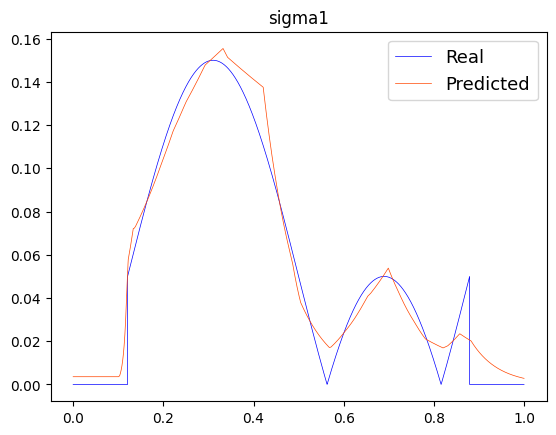

In [ ]:
n = 3000

t = np.linspace(0,2*np.pi,n)
sigma1_theoretical = np.abs((0.5+np.sin(t))*.1)

t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))
sigma1_theoretical = np.concatenate((np.zeros(int(n/10)), sigma1_theoretical, np.zeros(int(n/10))))

plt.plot(T,sigma1_theoretical, 'b', linewidth=0.5, label = 'Real')
plt.plot(T,np.exp(pred_log_sigma_1), 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('sigma1')
plt.legend(loc ="upper right", fontsize="13")
plt.savefig("case2_sigma1.png")
plt.show()


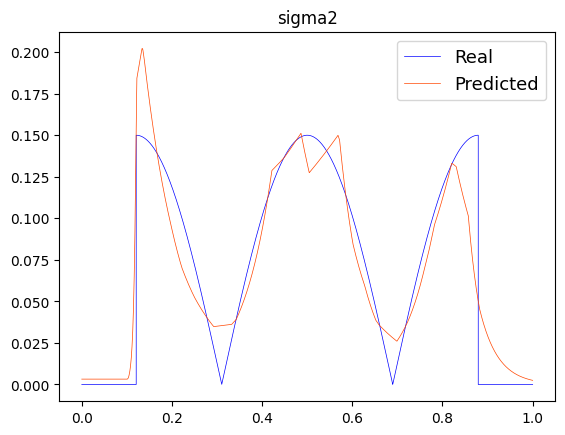

In [ ]:
t = np.linspace(0,2*np.pi,n)
sigma2_theoretical = np.abs(np.cos(t)*.15)

t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))
sigma2_theoretical = np.concatenate((np.zeros(int(n/10)), sigma2_theoretical,np.zeros(int(n/10))))

plt.plot(T, sigma2_theoretical, 'b', linewidth=0.5, label = 'Real')
plt.plot(T,np.exp(pred_log_sigma_2), 'orangered', linewidth=0.5, label = 'Predicted')


plt.title('sigma2')
plt.legend(loc ="upper right", fontsize="13")
plt.savefig("case2_sigma2.png")
plt.show()


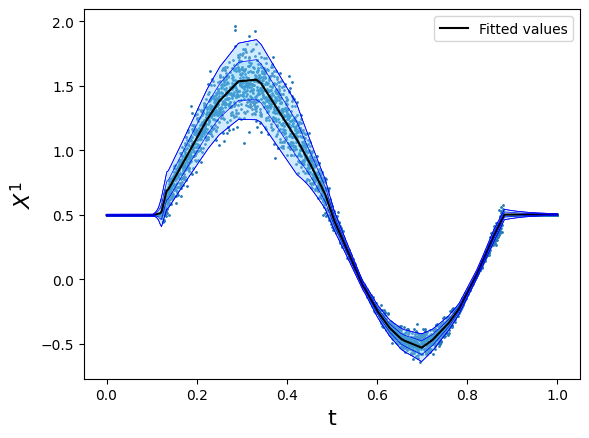

In [ ]:
# show the data along with the fit plus/minus 2-times the standard deviation
t_pred = T

plt.scatter(T,x1,marker='o', s=1)
plt.plot(t_pred,pred_mu_1,c="black", label='Fitted values')

pred_1_sd_p = pred_mu_1+(np.exp(pred_log_sigma_1))
pred_1_sd_m = pred_mu_1-(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_1+2*(np.exp(pred_log_sigma_1))
pred_2_sd_m = pred_mu_1-2*(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_1+2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_1-2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("simulated data")

plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{1}$", fontsize=16)
plt.legend()
plt.savefig("case2_x1_pred.png")
plt.show()

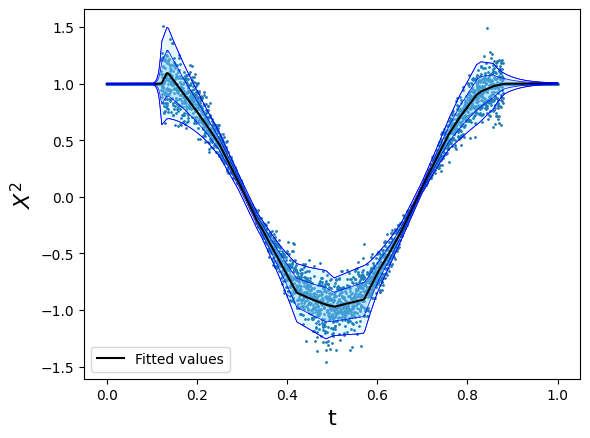

In [ ]:
plt.clf()

plt.scatter(T,x2,marker='o', s=1)
plt.plot(t_pred,pred_mu_2,c="black", label='Fitted values')

pred_1_sd_p = pred_mu_2+(np.exp(pred_log_sigma_2))
pred_1_sd_m = pred_mu_2-(np.exp(pred_log_sigma_2))

# plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
# plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_2+2*(np.exp(pred_log_sigma_2))
pred_2_sd_m = pred_mu_2-2*(np.exp(pred_log_sigma_2))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_2+2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_2-2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("simulated data")

plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{2}$", fontsize=16)
plt.legend()
plt.savefig("case2_x2_pred.png")
plt.show()

## CASE 3 - zmienne mu_1, mu_2, sigma_1, sigma_2 oraz korelacja

In [ ]:
t_, x1, x2 = create_sine_data_3(n = 3000)

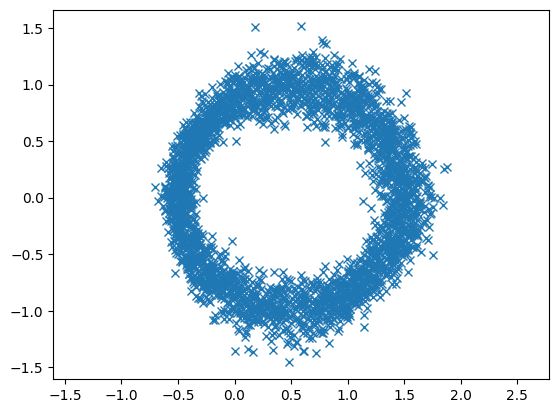

In [ ]:
plt.plot(x1, x2, 'x')
plt.axis('equal')

plt.savefig("case3_x1x2.png")
plt.show()



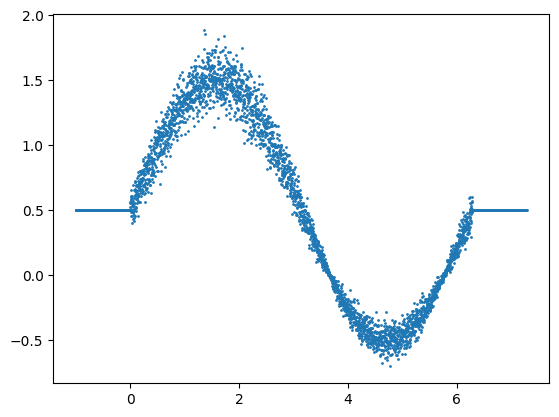

In [ ]:
plt.scatter(t_, x1,marker='o', s=1)

plt.savefig("case3_x1.png")
plt.show()

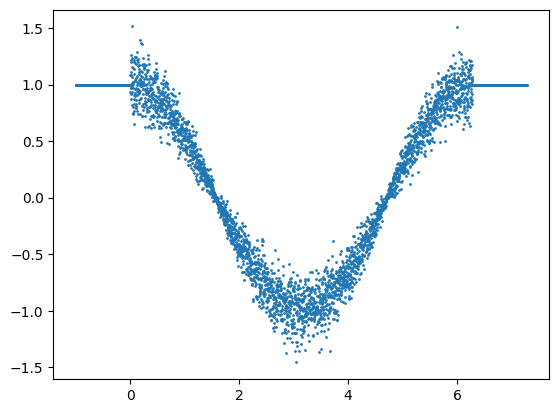

In [ ]:
plt.scatter(t_, x2,marker='o', s=1)

plt.savefig("case3_x2.png")
plt.show()

In [ ]:
model =  Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='linear'))

model.compile(loss=my_NLL_loss,optimizer="adam",metrics=[my_NLL_loss])
# summarize model along with number of model weights
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                40        
                                                                 
 dense_9 (Dense)             (None, 50)                1050      
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dense_11 (Dense)            (None, 5)                 105       
                                                                 
Total params: 2,215
Trainable params: 2,215
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x = np.array([x1,x2]).T
x = x.astype("float32")

T  = (t_ - t_.min(axis=0)) / (t_.max(axis=0) - t_.min(axis=0))
T = T.astype("float32")

In [ ]:
history=model.fit(T, x,
                  batch_size=16,
                  epochs=1000,
                  verbose=1
                 )

Epoch 1/1000
225/225 [==============================] - 3s 4ms/step - loss: 2.6638 - my_NLL_loss: 2.6638
Epoch 2/1000
225/225 [==============================] - 1s 4ms/step - loss: -12.6328 - my_NLL_loss: -12.6328
Epoch 3/1000
225/225 [==============================] - 1s 4ms/step - loss: -19.5819 - my_NLL_loss: -19.5819
Epoch 4/1000
225/225 [==============================] - 1s 5ms/step - loss: -29.4418 - my_NLL_loss: -29.4418
Epoch 5/1000
225/225 [==============================] - 1s 5ms/step - loss: -42.1781 - my_NLL_loss: -42.1781
Epoch 6/1000
225/225 [==============================] - 1s 4ms/step - loss: -49.2765 - my_NLL_loss: -49.2765
Epoch 7/1000
225/225 [==============================] - 1s 4ms/step - loss: -53.3172 - my_NLL_loss: -53.3172
Epoch 8/1000
225/225 [==============================] - 1s 4ms/step - loss: -55.4282 - my_NLL_loss: -55.4282
Epoch 9/1000
225/225 [==============================] - 1s 4ms/step - loss: -57.0575 - my_NLL_loss: -57.0575
Epoch 10/1000
225/225 [

In [ ]:
prediction = model.predict(T)

file = open('case3_result', 'wb')
pickle.dump(prediction, file)
file.close()

pred_mu_1=prediction[:,0]
pred_mu_2=prediction[:,1]
pred_log_sigma_1=prediction[:,2]
pred_log_sigma_2=prediction[:,3]
pred_rho=prediction[:,4]

pred_rho=2*tf.math.sigmoid(pred_rho) - 1

113/113 [==============================] - 0s 2ms/step


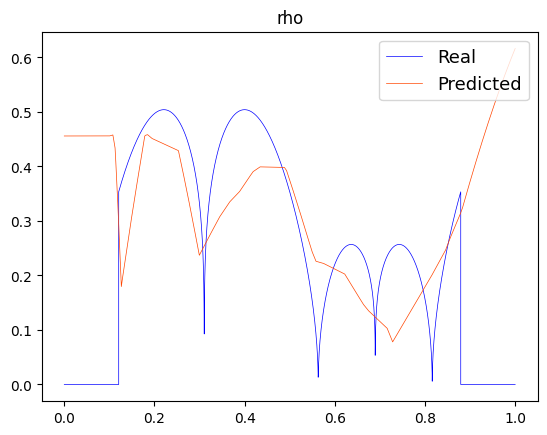

In [ ]:
t = np.linspace(0,2*np.pi,n)

rho_theoretical = 0.5*np.sqrt(np.abs((0.5+np.sin(t)))*np.sqrt(np.abs(np.cos(t))))

t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))
rho_theoretical = np.concatenate((np.zeros(int(n/10)), rho_theoretical,np.zeros(int(n/10))))

plt.plot(T, rho_theoretical, 'b', linewidth=0.5, label = 'Real')
plt.plot(T, pred_rho, 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('rho')
plt.legend(loc ="upper right", fontsize="13")
plt.savefig("case3_rho.png")
plt.show()



# plt.plot(X, pred_rho, 'b', linewidth=0.5)
# plt.title('rho')
# plt.show()

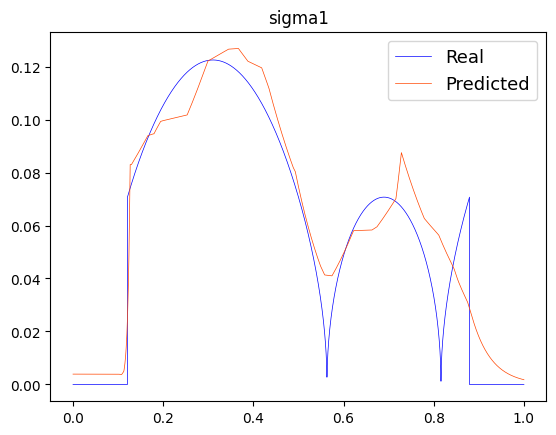

In [ ]:
n = 3000

t = np.linspace(0,2*np.pi,n)
sigma1_theoretical = 0.1*np.sqrt(np.abs(0.5+np.sin(t)))

t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))
sigma1_theoretical = np.concatenate((np.zeros(int(n/10)), sigma1_theoretical,np.zeros(int(n/10))))

plt.plot(T,sigma1_theoretical, 'b', linewidth=0.5, label = 'Real')
plt.plot(T,np.exp(pred_log_sigma_1), 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('sigma1')
plt.legend(loc ="upper right", fontsize="13")
plt.savefig("case3_sigma1.png")
plt.show()


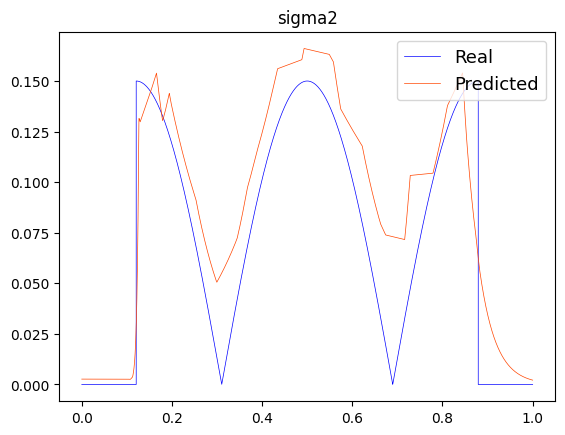

In [ ]:
t = np.linspace(0,2*np.pi,n)
sigma2_theoretical = np.abs(np.cos(t)*.15)

t_ = np.concatenate((np.linspace(-1,0,int(n/10)),t,np.linspace(max(t),max(t)+1,int(n/10))))
sigma2_theoretical = np.concatenate((np.zeros(int(n/10)), sigma2_theoretical,np.zeros(int(n/10))))

plt.plot(T, sigma2_theoretical, 'b', linewidth=0.5, label = 'Real')
plt.plot(T,np.exp(pred_log_sigma_2), 'orangered', linewidth=0.5, label = 'Predicted')

plt.title('sigma2')
plt.legend(loc ="upper right", fontsize="13")
plt.savefig("case3_sigma2.png")
plt.show()


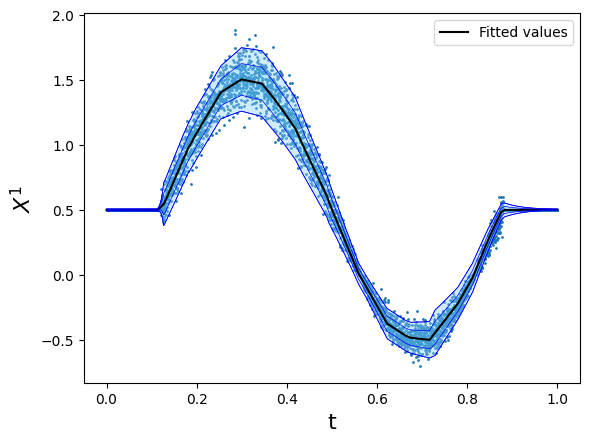

In [ ]:
# show the data along with the fit plus/minus 2-times the standard deviation
t_pred = T

plt.scatter(T,x1,marker='o', s=1)
plt.plot(t_pred,pred_mu_1,c="black", label='Fitted values')

pred_1_sd_p = pred_mu_1+(np.exp(pred_log_sigma_1))
pred_1_sd_m = pred_mu_1-(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_1+2*(np.exp(pred_log_sigma_1))
pred_2_sd_m = pred_mu_1-2*(np.exp(pred_log_sigma_1))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_1+2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_1-2*(np.exp(pred_log_sigma_1)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("simulated data $X^{1}(t)$", fontsize=16)

plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{1}$", fontsize=16)
plt.legend()
plt.savefig("case3_x1_pred.png")
plt.show()

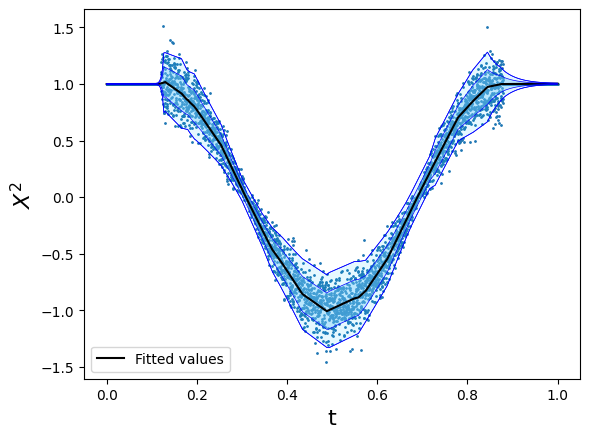

In [ ]:
plt.clf()

plt.scatter(T,x2,marker='o', s=1)
plt.plot(t_pred,pred_mu_2,c="black", label='Fitted values')

pred_1_sd_p = pred_mu_2+(np.exp(pred_log_sigma_2))
pred_1_sd_m = pred_mu_2-(np.exp(pred_log_sigma_2))

# plt.plot(x_pred,pred_2_sd_p, 'b', linewidth=0.5)
# plt.plot(x_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu_2+2*(np.exp(pred_log_sigma_2))
pred_2_sd_m = pred_mu_2-2*(np.exp(pred_log_sigma_2))

plt.plot(t_pred,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(t_pred,pred_2_sd_m, 'b', linewidth=0.5)

plt.plot(t_pred,pred_mu_2+2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)
plt.plot(t_pred,pred_mu_2-2*(np.exp(pred_log_sigma_2)), 'b', linewidth=0.5)

plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=0.4, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([t_pred, t_pred[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=0.1, fc='deepskyblue', ec='None')

# plt.title("simulated data $X^{2}(t)$", fontsize=16)

plt.xlabel("t", fontsize=16)
plt.ylabel("$X^{2}$", fontsize=16)
plt.legend()
plt.savefig("case3_x2_pred.png")
plt.show()